# Mantid FFT Algorithm

- Here we test how the Mantid algorithm for calculating the fast fourier transform of a signal works
- we wanted to gaurentee that the algorithm in Mantid workbench was working properly
- the code for the fft here is taken from open-source Mantid repository
- needed to extract it to use it on non-nexus file data (mantid only works with data from Oak Ridge)
- it is slightly modified for my purposes

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from matplotlib import cm
import math
import sys
import time
from scipy.optimize import least_squares
import glob
import scipy.fft
import os
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
os.chdir('C:/Users/chris/Downloads')

In [ ]:
#Testing the fft algorithm in mantid
# we test on data published earlier with known results to compare against

#mdata = np.load('pdf_bixbyite_7K.npy')
mat = np.load('magnetic_scat_bixbyite_7K.npy')
xx = np.linspace(-13.688,13.688,501) #Reciprocal Angstroms
yy = np.linspace(-13.688,13.688,501) 
zz = np.linspace(-13.688,13.688,501)
X1 = np.linspace(-20.5,20.5,501) #HKL units
Y1 = np.linspace(-20.5,20.5,501)
Z1 = np.linspace(-20.5,20.5,501)
XX = np.linspace(-57.38,57.38,501) #PDF in Angstroms
YY = np.linspace(-57.38,57.38,501)
ZZ = np.linspace(-57.38,57.38,501)
signal=mat
signal[np.isnan(signal)]=0
signal[np.isinf(signal)]=0
signal=np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(signal)))
number_of_bins = signal.shape
signal_real=signal.real
extents=[]
for d in (xx,yy,zz):
    dim = d.shape[0]
    if dim == 1:
        fft_dim = 1./(max(d)-min(d))
        extents.append(-fft_dim/2.)
        extents.append(fft_dim/2.)
    else:
        fft_dim=np.fft.fftshift(np.fft.fftfreq(dim, (max(d)-min(d))/dim))
        extents.append(fft_dim[0])
        extents.append(fft_dim[-1])
x1=np.linspace(extents[0],extents[1],number_of_bins[0])
x2=np.linspace(extents[2],extents[3],number_of_bins[1])
x3=np.linspace(extents[4],extents[5],number_of_bins[2])

In [2]:
#Testing the fft algorithm in mantid
#mdata = np.load('pdf_bixbyite_7K.npy')
mat = np.load('ws.npy')
xx = np.linspace(-6.01,6.01,601) #HKL units
yy = np.linspace(-6.01,6.01,601)
zz = np.linspace(-8.4,8.4,560)
signal=mat
signal[np.isnan(signal)]=0
signal[np.isinf(signal)]=0
signal=np.fft.fftshift(np.fft.fftn(np.fft.ifftshift(signal)))
number_of_bins = signal.shape
signal_real=signal.real
extents=[]
for d in (xx,yy,zz):
    dim = d.shape[0]
    if dim == 1:
        fft_dim = 1./(max(d)-min(d))
        extents.append(-fft_dim/2.)
        extents.append(fft_dim/2.)
    else:
        fft_dim=np.fft.fftshift(np.fft.fftfreq(dim, (max(d)-min(d))/dim))
        extents.append(fft_dim[0])
        extents.append(fft_dim[-1])
x1=np.linspace(extents[0],extents[1],number_of_bins[0])
x2=np.linspace(extents[2],extents[3],number_of_bins[1])
x3=np.linspace(extents[4],extents[5],number_of_bins[2])

In [3]:
"""class to slice through and visualize three-dimensional data"""

import numpy as np
from scipy.interpolate import interpn

class Visualize:
    """create object containing three-dimensional data.
    
    Args:
        m (numpy array): signal array (3D)
        x (numpy array): x-dimension coordinates (1D)
        y (numpy array): y-dimension coordinates (1D)
        z (numpy array): z-dimension coordinates (1D)
    """
    def __init__(self, m=None, x=None, y=None, z=None):
            
        self.m = m
        self.x = x
        self.y = y
        self.z = z
        self.a = None # these two instance attributes will construct an arbitrary grid
        self.b = None
        if m is None:
            self.m = np.array([])
        if x is None:
            self.x = np.array([])
        if y is None:
            self.y = np.array([])
        if z is None:
            self.z = np.array([])
        
    def three_points(self, p1, p2, p3):
        """find normal vector to the plane created by the three given points
        """
        
        # find two vectors from the three points which lie on the desired plane
        vec1 = p2 - p1
        vec2 = p3 - p1
        # now cross these two vectors to find a vector normal to the plane
        normal = np.cross(vec1, vec2)
    
        # now calculate the centroid of the three points given
        x_pos = (p1[0] + p2[0] + p3[0]) / 3
        y_pos = (p1[1] + p2[1] + p3[1]) / 3
        z_pos = (p1[2] + p2[2] + p3[2]) / 3
        cen_pt = np.array([x_pos, y_pos, z_pos])
        print('Center Point:', cen_pt)
        
        return normal, cen_pt
    
    def make_slice(self, len_a=None, len_b=None, dr=None, use_norm=None, 
                   cen_pt=None, normal=None, p1=None, p2=None, p3=None):
        """generate a slice through the dataset
        
        Args:
            side_len: the side length of the square slice to be taken through the data
            dr: determines the spacing of the grid (if dr=0.5, then there are 2 measurements every angstrom)
            use_norm: When True, will create slice from user given normal vector and center point. When
                false, will create slice from three points given by the user
            cen_pt: The center of the desired slice. Used when use_norm is True
            normal: The normal vector to desired plane. Used when use_norm is True
            p1, p2, p3: Three points in 3D space given as numpy arrays. The desired plane goes through these points.
                Used when use_norm is False
            
        Returns:
            2D array, representing slice through 3D dataset
        """
        if dr is None:
            dr = 1
        if use_norm is None:
            use_norm = True
        if len_a is None:
            len_a = 10
        if len_b is None:
            len_b = 10
        if cen_pt is None:
            cen_pt = np.array([0, 0, 0])
        if normal is None:
            normal = np.array([1, 0, 0])
        if p1 is None:
            p1 = np.array([0, 1, 0])
        if p2 is None:
            p2 = np.array([1, 0, 0])
        if p3 is None:
            p3 = np.array([0, 0, 1])
        
        # First check if use_norm is False. If so, access three_points function 
            # to calculate the normal and cen_pt of the desired plane
        if use_norm is False:
            normal, cen_pt = self.three_points(p1, p2, p3)
         
        # ensure that our basis vector v1 is not the same as normal
        v1 = np.array([1, 0, 0])
        if np.allclose(v1, normal):
            v1 = np.array([0, 1, 0])
    
        # now make a matrix which will reflect any vector onto the orthogonal
            # complement of the normal vec, which is our desired plane
        # This is done by subtracting from the vector its component along the normal vector
        m_norm = np.eye(3) - (np.outer(normal, normal.T) / normal.T.dot(normal))
        
        # now reflect v1 using m_norm
        v1 = m_norm.dot(v1)
        # and create a new vector v2 that is orthogonal to both v1 and normal
        v2 = np.cross(normal, v1)
        # we now have 2 vectors to form our plane
    
        # now create and normalize Q, which will rotate an arbitrary 
            # slice to the orientation we desire
        Q = np.column_stack((v1, v2, np.zeros_like(v1)))
        Q[:,:2] /= np.linalg.norm(Q[:,:2], axis = 0)
    
        # now create an arbitrary slice
        self.a = np.arange(-len_a / 2, len_a / 2, dr)
        self.b = np.arange(-len_b / 2, len_b / 2, dr)
        self.a = np.append(self.a, len_a / 2)
        self.b = np.append(self.b, len_b / 2)
        A,B = np.meshgrid(self.a, self.b)
        locations = np.array([A.reshape(-1), B.reshape(-1), np.zeros(A.size)])  # the slice starts on the x-y plane
        # now move locations onto our two vectors, and add cen_pt to move slice into position
        locations = Q.dot(locations).T + (cen_pt)
    
        # now we need to interpolate our 3Dmpdf function over this slice
        points = (self.x, self.y, self.z)
        interp = interpn(points, self.m, locations)  # list of values of 3Dmpdf at locations
        slice1 = interp.reshape(len(self.b),len(self.a))
        
        return slice1

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
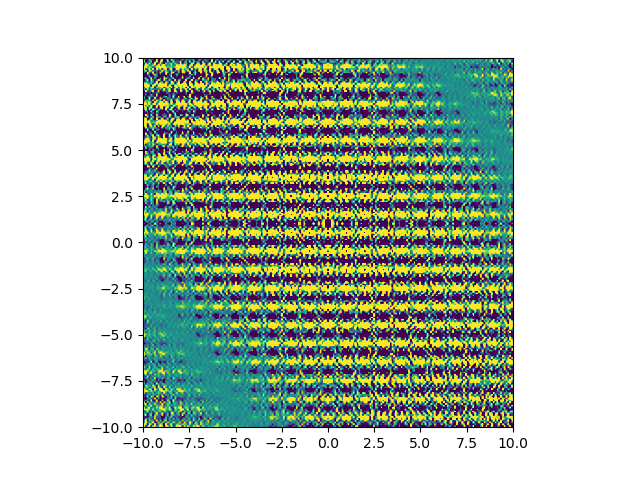

In [8]:
obj = Visualize(signal_real,x1,x2,x3)
plane=obj.make_slice(20,20,0.1,np.array([0,0,0]),np.array([0,0,1]))
plt.imshow(plane,extent=[-10,10,-10,10],vmin=-.15,vmax=.15)
plt.show()